In [7]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import torch.nn.functional as F
from typing import Callable, Union, Tuple, Optional, List

from time import time
import matplotlib.pyplot as plt
import io

import importlib
import sys
sys.path.append('..')
import util
importlib.reload(util)
importlib.reload(util.general)
importlib.reload(util.data)
importlib.reload(util.nn)
importlib.reload(util.nn.unet3d)
importlib.reload(util.nn.bayes)
import util

def mask_plots(scan: torch.Tensor, masks: list[torch.Tensor], pmasks: list[torch.Tensor]):
    fig, axes = plt.subplots(3, len(masks), figsize=(20, 10))
    if len(masks) == 1:
        axes = axes[:, None]
    
    for i, (mask, pmask) in enumerate(zip(masks, pmasks)):
        axes[0][i].axis('off')
        axes[0][i].imshow(scan[0, 0, scan.shape[2] // 2].detach().cpu(), cmap='gray')
        axes[1][i].axis('off')
        axes[1][i].imshow(mask[0, 0, mask.shape[2] // 2].detach().cpu(), cmap='gray')
        axes[2][i].axis('off')
        axes[2][i].imshow(pmask[0, 0, pmask.shape[2] // 2].detach().cpu(), cmap='gray')
    
    # plt.show()
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return np.array(Image.open(buf))
 

log_board = util.diagnostics.LogBoard('log_dir', 6005)
log_board.launch()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
train = util.data.SenNet(
    chunk_size=16,
    guarantee_vessel=0.5,
    samples=[
        "/train/kidney_1_dense"
    ]
)

test = util.data.SenNet(
    chunk_size=16,
    guarantee_vessel=0.2,
    samples=[
        "/train/kidney_2"
    ]
)

Loading /train/kidney_1_dense/images from cache


TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



Loading /train/kidney_1_dense/labels from cache


E0109 00:29:32.426860 140338137265344 program.py:298] TensorBoard could not bind to port 6005, it was already in use
ERROR: TensorBoard could not bind to port 6005, it was already in use


Loading /train/kidney_2/images from cache
Loading /train/kidney_2/labels from cache


In [ ]:
def augment() -> callable:
    rx, ry, rz = np.random.randint(0, 4, 3)
    fx, fy, fz = np.random.random(3) < 0.5

    def aug(u:  torch.Tensor) -> torch.Tensor:
        u = torch.rot90(u, k=rx, dims=(2, 3))
        u = torch.rot90(u, k=ry, dims=(2, 4))
        u = torch.rot90(u, k=rz, dims=(3, 4))
        if fx:
            u = torch.flip(u, dims=(2,))
        if fy:
            u = torch.flip(u, dims=(3,))
        if fz:
            u = torch.flip(u, dims=(4,))
        return u.contiguous()
    return aug

In [ ]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

class SweepCube(Dataset):
    def __init__(self, data: torch.Tensor, chunk_size: int, stride: Optional[int] = None):
        self.data = data
        self.chunk_size = chunk_size
        self.stride = stride if stride is not None else chunk_size // 2

        self.patches = (
            (self.data.shape[1] - self.chunk_size) // self.stride + 1,
            (self.data.shape[2] - self.chunk_size) // self.stride + 1,
            (self.data.shape[3] - self.chunk_size) // self.stride + 1,
        )

    def __len__(self):
        return (self.patches[0] * self.patches[1] * self.patches[2])

    def __getitem__(self, i):
        x, y, z = np.unravel_index(i, self.patches)
        x, y, z = x * self.stride, y * self.stride, z * self.stride

        return self.data[
            :,
            x:x+self.chunk_size,
            y:y+self.chunk_size,
            z:z+self.chunk_size,
        ], torch.tensor([x, y, z])

class ScanInferece(nn.Module):
    def __init__(self, model: util.UNet3D, patch_size: int, stride: Optional[int] = None, batch_size: int = 32):
        super().__init__()
        self.model = model
        self.patch_size = patch_size
        self.stride = stride
        self.batch_size = batch_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        agg_p = torch.zeros_like(x)
        scan_loader = DataLoader(
            SweepCube(x, self.patch_size, self.stride),
            batch_size=self.batch_size,
            shuffle=True
        )
    
        for xs, positions in scan_loader:
            p_y = F.sigmoid(self.model(xs)[-1])
            for p, pos in zip(p_y, positions):
                agg_p[
                    :,
                    pos[0]:pos[0] + self.patch_size,
                    pos[1]:pos[1] + self.patch_size,
                    pos[2]:pos[2] + self.patch_size,
                ] += (p - 0.5) # center around 0
        
        return agg_p > 0




In [ ]:
log_board.clear('train')
log_board.clear('val')

KeyboardInterrupt: 

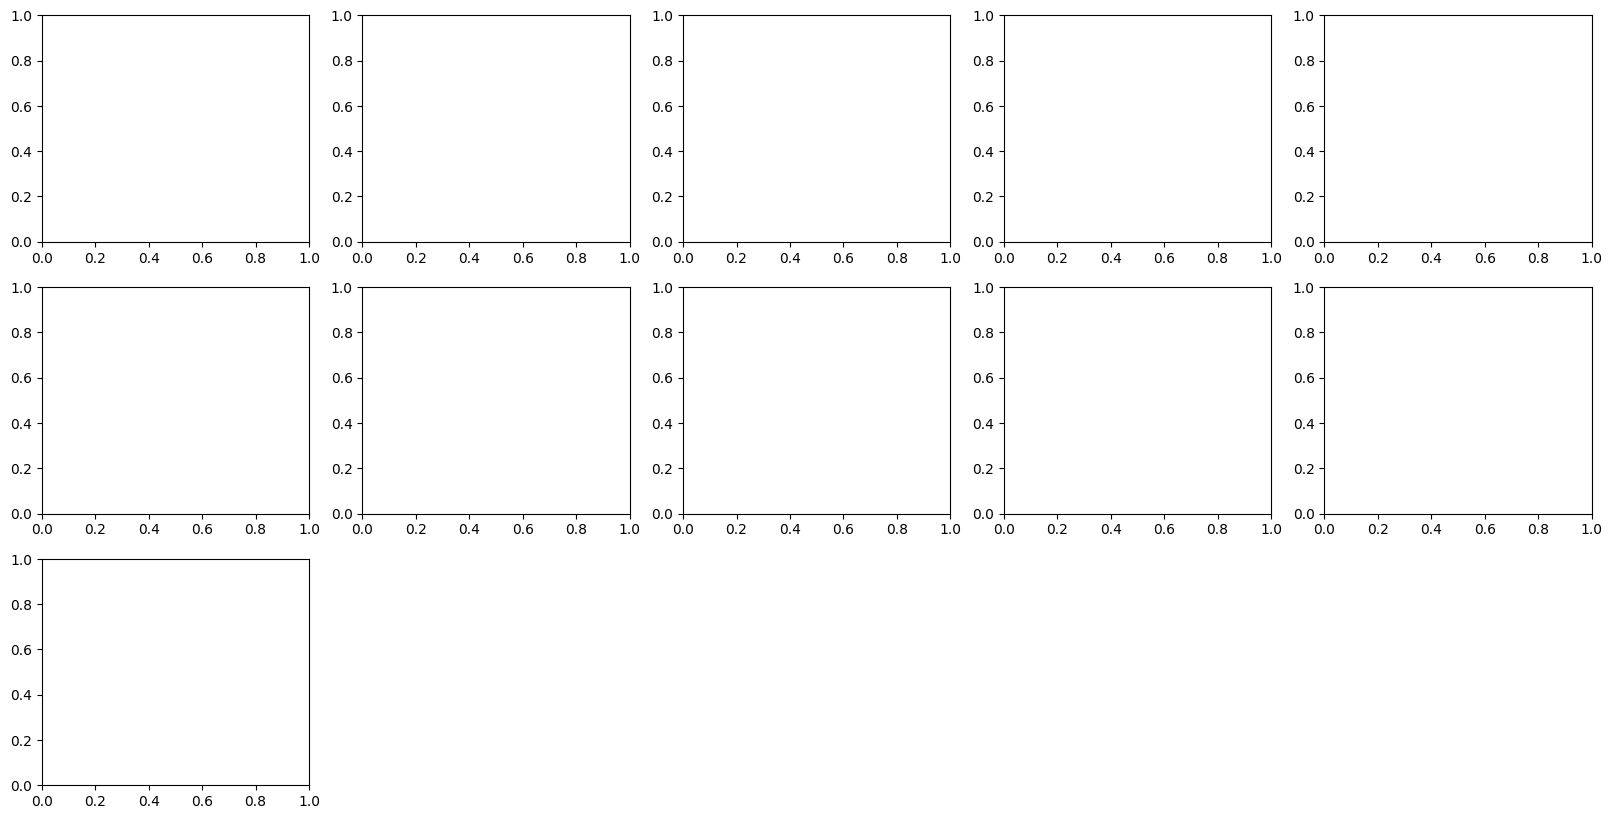

In [ ]:
# Probably switch back to 3x3 conv for the final layer

patch_size = 16
epochs = 100
batch_size = 6
t_logger = log_board.get_logger('train')
v_logger = log_board.get_logger('val')

train_data = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_data = DataLoader(test, batch_size=batch_size, shuffle=True)

model = util.UNet3D(
    Conv3d=util.nn.Conv3DNormed,
    block_depth=8,
    batch_norm=True,
    # target_var=0.1,
).to(device)
# inference = ScanInferece(model, patch_size=16, stride=8, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
dice_loss = util.DiceLoss(
    gamma=2,
).to(device)
focal_loss = util.BinaryFocalLoss(
    alpha=0.3,
    gamma=2,
)
nn.BCELoss()

t = time()
for epoch in range(epochs):
    for i, (x, y, _) in enumerate(train_data):
        step = epoch * len(train_data) + i

        # Prepare data
        x, y = x.float().to(device), y.float().to(device)
        # x = (x - x.mean(dim=0)) / x.std(dim=0)
        x = (x - x.mean(dim=list(range(1, x.ndim)), keepdim=True)) / x.std(dim=list(range(1, x.ndim)), keepdim=True)
        # x = x/255
        aug = augment()
        x, y = aug(x), aug(y)

        # Collect values
        logits = model(x)
        p_y = [torch.sigmoid(logit) for logit in logits]
        has_vessels = p_y[0].detach() > 0.5
        p_y = [p_y[0]] + [p_y[i] * has_vessels for i in range(1, len(p_y))]
        masks = model.deep_masks(y)

        # Dice + Focal loss
        # dloss = torch.stack([
        #     (dice_loss(logits, mask) * (1 ** (len(logits) - i - 1)) * (has_vessels.squeeze() if i > 0 else 1)).mean()
        #     for i, (logits, mask) in enumerate(zip(
        #         logits[1:],
        #         masks[1:]
        #     ))
        # ]).mean() * 0
        # dloss = 0
        floss = (((p_y[0] -  masks[0]) ** 2) ** 1).mean()
        loss =  floss
        # ]).mean() + torch.stack([
        #     focal_loss(logits, mask) * (1 ** (len(logits) - i - 1))
        #     for i, (logits, mask) in enumerate(zip(
        #         logits,
        #         masks
        #     ))
        # ]).mean()

        # Deep sup penalty to learn distributional space of masks faster
        # mask_dist_penalty = torch.stack([
        # #     ((p.float().std(dim=list(range(1, p.ndim))) - m.std(dim=list(range(1, p.ndim)))) ** 2).mean()
        # #     for p, m in zip(p_y, masks)
        # # ] + 
        # # [
        #     ((p.mean(dim=list(range(1, p.ndim))) - m.mean(dim=list(range(1, p.ndim)))) ** 2).mean()
        #     for p, m in zip(p_y, masks)
        # ]
        # ).mean()
        # loss += mask_dist_penalty

        
        # Step grad
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # train.guarantee_vessel = (1 - max(0.8, (step / 10000)))

        # Train logging
        with torch.no_grad():
            dice = util.dice_coefficient(
                (p_y[-1] > 0.5).float(), y
            ).item()
            t_logger.add_scalar('loss', loss, step)
            t_logger.add_scalar('dice', dice, step)
            t_logger.add_scalars('stats',{
                'out_std': p_y[-1].std(),
                'out_mean': p_y[-1].mean(),
                'vessel_density': y.mean(),
                'pred_density': (p_y[-1] > 0.5).float().mean(),
                'is_vessel_pred_mean': has_vessels.float().mean(),
                'is_vessel_true_mean': masks[0].float().mean(),
            }, step)

            # Validation logging
            if step % 10 == 0:
                model.eval()
                x, y, _ = next(iter(valid_data))
                x, y = x.float().to(device), y.float().to(device)
                # x = (x - x.mean(dim=0)) / x.std(dim=0)
                x = (x - x.mean(dim=list(range(1, x.ndim)), keepdim=True)) / x.std(dim=list(range(1, x.ndim)), keepdim=True)
                # x = x/255
                masks = model.deep_masks(y)

                p_y = [F.sigmoid(logits) > 0.5 for logits in model(x)]
                has_vessels = p_y[0] > 0.5
                p_y = [p_y[0]] + [p_y[i] * has_vessels for i in range(1, len(p_y))]
                dice = util.dice_coefficient(
                    p_y[-1], y
                )

                v_logger.add_scalar('dice', dice, step)
                v_logger.add_image('masks', mask_plots(x, masks, p_y), step, dataformats='HWC')
                t_logger.add_scalar('time', time() - t, step)
                t = time()
                model.train()

In [ ]:
import os

os.makedirs('./bin', exist_ok=True)

torch.save(model.state_dict(), "./bin/group_norm.pth")

In [ ]:
import util

model = util.UNet3D(
    Conv3d=util.nn.Conv3DNormed,
    block_depth=8,
    batch_norm=True,
)
model.load_state_dict(torch.load("./bin/group_norm.pth"))
model.eval()

test = util.data.SenNet(
    chunk_size=16,
    guarantee_vessel=0.5,
    samples=[
        "/train/kidney_2"
    ]
)

agg_dice = util.AggDice(test[0][0].unsqueeze(0), test[0][1].unsqueeze(0))


In [ ]:
test[0][0].unsqueeze(0).shape

torch.Size([1, 1, 16, 16, 16])

In [ ]:
with torch.no_grad():
    x, y = next(iter(valid_data))
    x, y = x.float().to(device), y.float().to(device)
    x = (x - x.mean()) / x.std()
    pred_y = inference(x[0])

In [ ]:
scan = x.squeeze(0).cpu().numpy()
mask = y.squeeze(0).cpu().numpy()
pmask = pred_y.squeeze(0).cpu().numpy()

In [ ]:
x[0].squeeze(0).shape, pred_y.squeeze(0).shape

(torch.Size([32, 32, 32]), torch.Size([32, 32, 32]))

In [ ]:
_x = x[0].squeeze(0).cpu().numpy()
_y = y[0].squeeze(0).cpu().numpy()
_pred_y = pred_y[0].squeeze(0).cpu().numpy()

In [ ]:
Display(_x, _y, _pred_y)()

interactive(children=(IntSlider(value=0, description='idx_td', max=31), Output()), _dom_classes=('widget-inter…

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

class Display:
    def __init__(self, scan: np.ndarray, mask: np.ndarray = None, pmask: np.ndarray = None):
        self.scan = scan
        self.mask = mask
        self.pmask = pmask

    def _show(self, idx_td):
        plt.axis('off')
        plt.imshow(self.scan[:, :, idx_td], cmap='gray')
        if self.mask is not None:
            plt.imshow(self.mask[:, :, idx_td], cmap='Blues', alpha=0.5)
        if self.pmask is not None:
            plt.imshow(self.pmask[:, :, idx_td], cmap='Greens', alpha=0.5)


    def __call__(self, side: bool = False):
        slider_top_down  = widgets.IntSlider(min=0, max=self.scan.shape[-1] - 1, step=1, value=0)
        interact(self._show, idx_td=slider_top_down)